In [154]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.combine_tools import apply_qc, to_str_intlike
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

%matplotlib inline

In [155]:
criteria_name = 'beh_all'
version = 'PrL_S1'
target_folder = '/root/capsule/scratch/manuscript/F_ephys_beh_action&outcome'

In [156]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
# load antidromic tagging info
# antidromic data
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)
# antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)

combined_tagged_units.drop(columns=['probe'], inplace=True, errors='ignore')
combined_tagged_units = combined_tagged_units.merge(combined_session_qc, on='session', how='left')
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8345 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8345 -> 5872 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5872 -> 5849 units passed
Applying items for in_df: [True]
 - in_df: 5849 -> 4216 units passed
Applying conditional bounds for y_loc
 - y_loc: 4216 -> 2953 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2953 -> 2938 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 2938 -> 1352 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 307
Number of non-opto rows after filtering: 1352


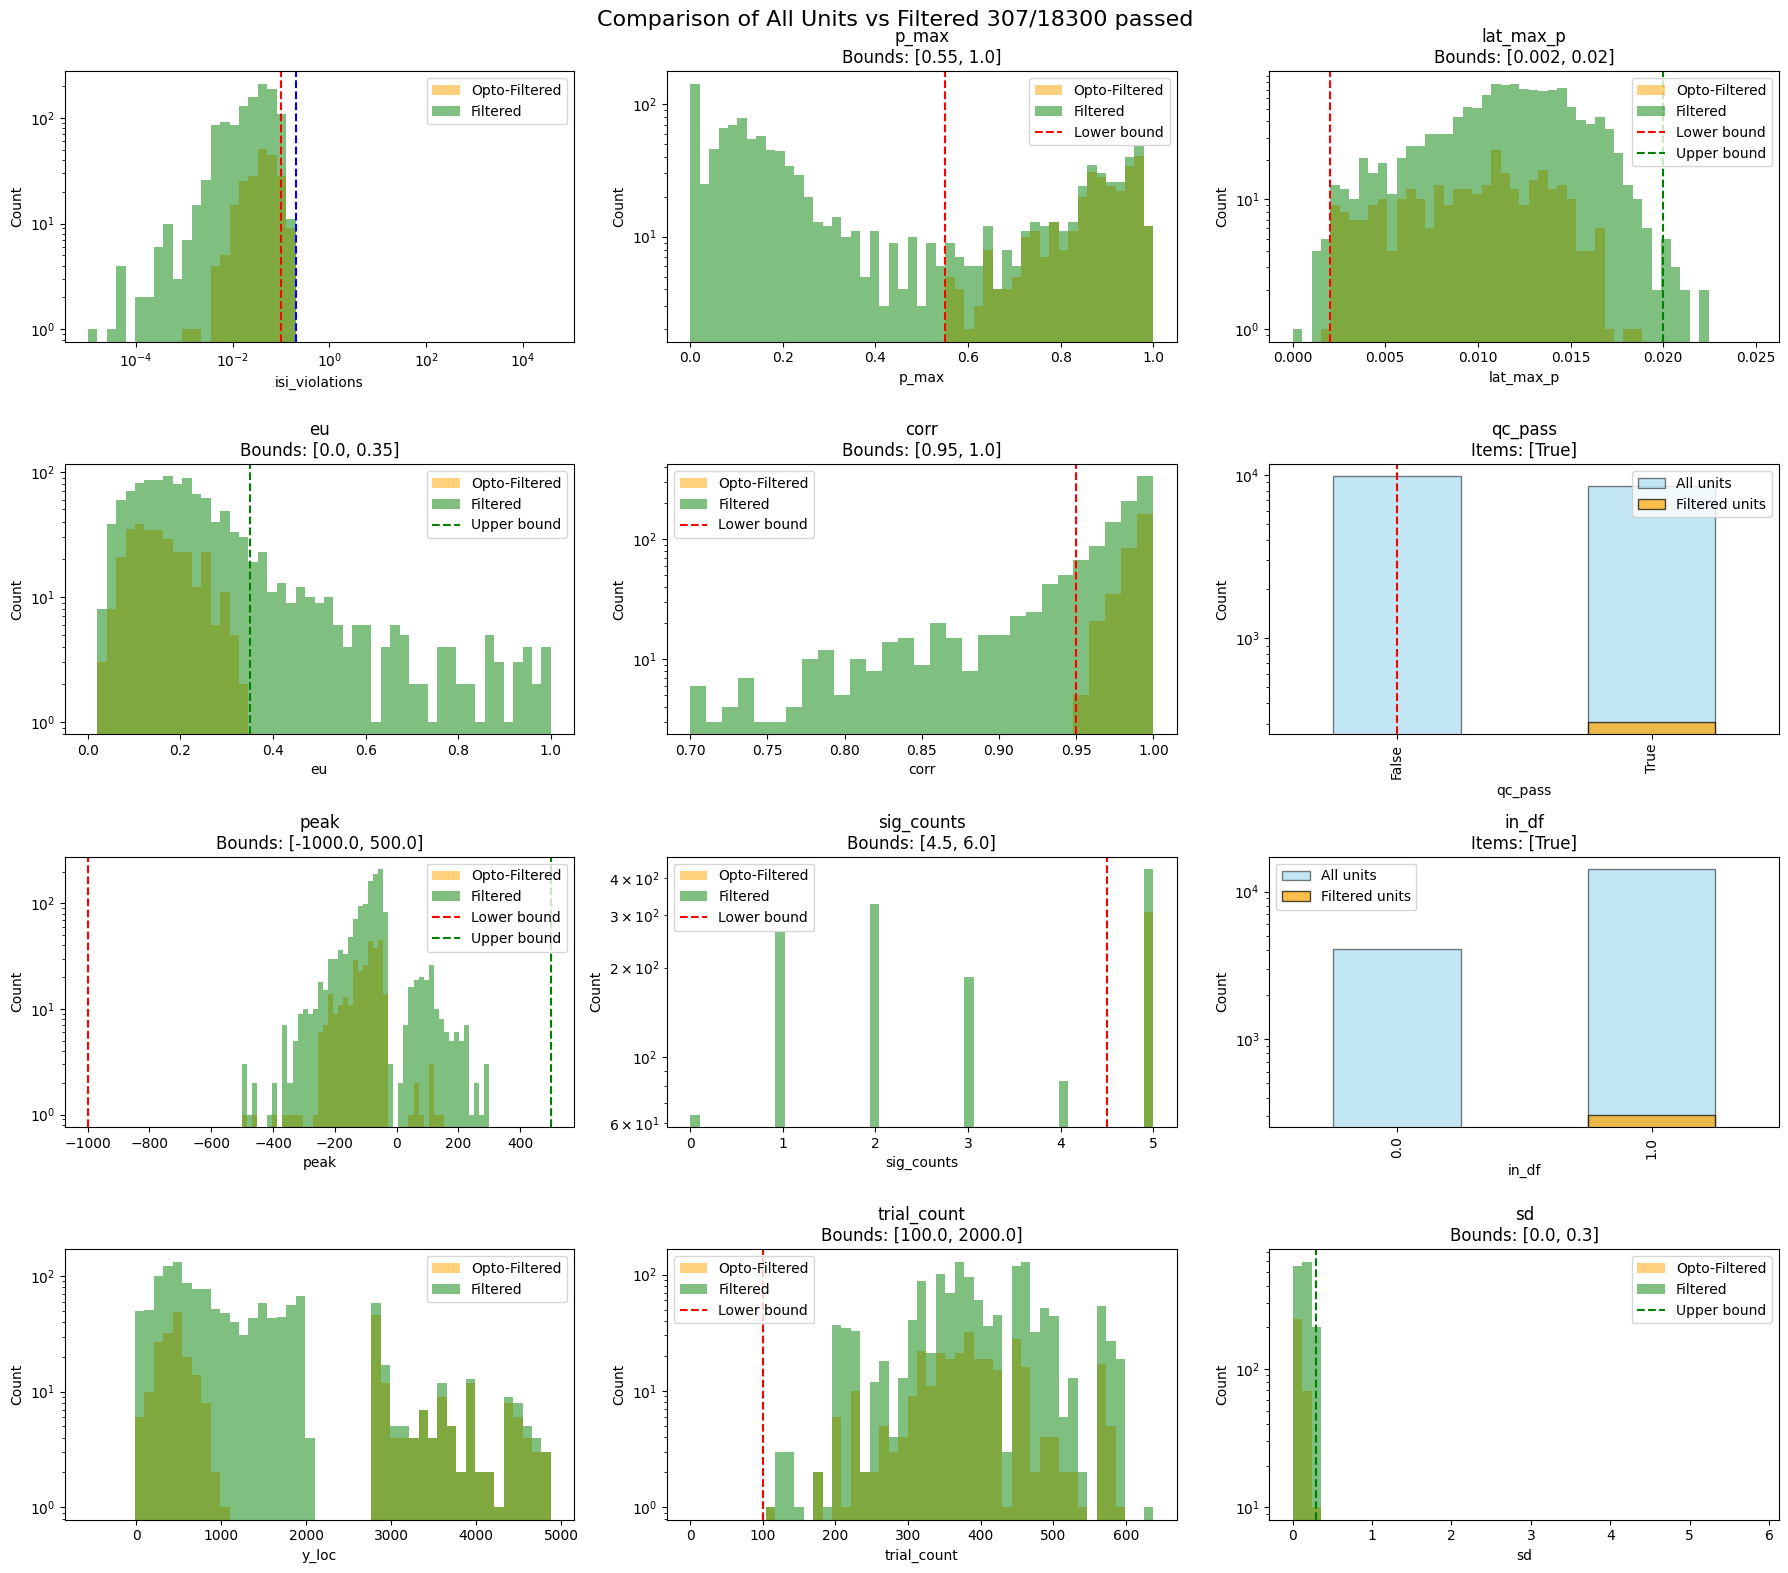

In [157]:
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints, plot_all=False, density=False)

In [158]:
# # perform auc on sliding window and define best window for each unit
# pre_event = -2.5
# post_event = 3
# binSize = 1.5
# stepSize = 0.1
# auc_mat = []           
# auc_max = []
# auc_max_ind = []
# labels = ['outcome', 'hit', 'svs']
# align = 'go_cue_time'
# loaded_session = None
# curr_session = None
# data_type = 'curated'
# model_name = 'stan_qLearning_5params'
# for ind, row in combined_tagged_units_filtered.iterrows():
#     session = row['session']                           
#     unit_id = row['unit'] 
#     print(session)
#     if loaded_session is None or loaded_session != session:
#         session_dir = session_dirs(session)
#         unit_tbl = get_unit_tbl(session, data_type)
#         whole_session_tbl = get_session_tbl(session)
#         whole_session_tbl['hit'] = whole_session_tbl['animal_response'].values==1
#         session_df = makeSessionDF(session, model_name = model_name)
#         session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
#         drift_data = load_trial_drift(session, data_type)
#         loaded_session = session
#     unit_drift = load_drift(session, unit_id, data_type=data_type)  
#     spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
#     session_df_curr = session_df.copy()
#     whole_session_df_curr = whole_session_tbl.copy()
#     spike_times_curr = spike_times.copy()
#     unit_trial_drift_curr = drift_data.load_unit(unit_id)
#     # tblTrials_curr = tblTrials.copy()
#     if unit_drift is not None:
#         if unit_drift['ephys_cut'][0] is not None:
#             spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
#             session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
#             whole_session_df_curr = whole_session_df_curr[whole_session_df_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
#         if unit_drift['ephys_cut'][1] is not None:
#             spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
#             session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
#             whole_session_df_curr = whole_session_df_curr[whole_session_df_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
#     if len(session_df_curr) < 5:
#         auc_mat.append(None)
#         auc_max.append(np.full((len(labels)), np.nan))
#         auc_max_ind.append(np.full((len(labels)), np.nan))
#         continue
#     align_time = session_df_curr[align].values
#     spike_matrix_auc, slide_times_auc = get_spike_matrix(spike_times_curr, align_time, 
#                                                 pre_event=pre_event, post_event=post_event, 
#                                                 binSize=binSize, stepSize=stepSize, kernel=False,
#                                                 tau_rise=0.001, tau_decay=0.08)
#     curr_auc = np.full((len(slide_times_auc), len(labels)), np.nan, dtype=float)
#     if align == 'go_cue_time':
#         spike_matrix_auc_all, slide_times_auc_all = get_spike_matrix(spike_times_curr, whole_session_df_curr['goCue_start_time'].values,
#                                                     pre_event=pre_event, post_event=post_event, 
#                                                     binSize=binSize, stepSize=stepSize, kernel=False,
#                                                     tau_rise=0.001, tau_decay=0.08)
#     elif align == 'outcome_time':
#         spike_matrix_auc_all, slide_times_auc_all = get_spike_matrix(spike_times_curr, whole_session_df_curr['reward_outcome_time'].values,
#                                                     pre_event=pre_event, post_event=post_event, 
#                                                     binSize=binSize, stepSize=stepSize, kernel=False,
#                                                     tau_rise=0.001, tau_decay=0.08)
#     for time_ind, time in enumerate(slide_times_auc):
#         # get the spike counts in the sliding window
#         spike_counts = spike_matrix_auc[:, time_ind]
#         spike_counts_all = spike_matrix_auc_all[:, time_ind]
#         # outcome
#         for label_ind, label in enumerate(labels):
#             if label != 'hit':
#                 focus = session_df_curr[label].values
#                 curr_auc[time_ind, label_ind] = roc_auc_score(focus, spike_counts)
#             else:
#                 focus = whole_session_df_curr[label].values
#                 if np.sum(focus == 0) < 5:
#                     curr_auc[time_ind, label_ind] = np.nan
#                 else:
#                     curr_auc[time_ind, label_ind] = roc_auc_score(focus, spike_counts_all)
    
#     curr_max_ind = np.nanargmax(np.abs(curr_auc-0.5), axis=0)
#     curr_max = curr_auc[curr_max_ind, np.arange(len(labels))]

#     auc_mat.append(curr_auc)
#     auc_max.append(curr_max)
#     auc_max_ind.append(curr_max_ind)

In [254]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score

# -----------------------------
# Your fixed params
# -----------------------------
pre_event = -4
post_event = 3
binSize = 2
stepSize = 0.1
labels = ['svs', 'hit']
labels = ['outcome']
align = 'outcome_time'
data_type = 'curated'
model_name = 'stan_qLearning_5params'

def _safe_max_ind(curr_auc):
    """Return (curr_max_ind, curr_max) robustly even if a whole label column is NaN."""
    n_times, n_labels = curr_auc.shape
    curr_max_ind = np.full(n_labels, np.nan)
    curr_max = np.full(n_labels, np.nan, dtype=float)

    score = np.abs(curr_auc - 0.5)
    for j in range(n_labels):
        col = score[:, j]
        if np.all(np.isnan(col)):
            continue
        k = int(np.nanargmax(col))
        curr_max_ind[j] = k
        curr_max[j] = curr_auc[k, j]
    return curr_max_ind, curr_max


def process_session_unit(row):
    """
    row: a pandas Series from combined_tagged_units_filtered
    returns: (curr_auc or None, curr_max, curr_max_ind)
    """
    session = row['session']
    unit_id = row['unit']

    # ---- load session-level things (per job) ----
    _ = session_dirs(session)  # if you need side effects; otherwise remove
    unit_tbl = get_unit_tbl(session, data_type)
    whole_session_tbl = get_session_tbl(session)
    whole_session_tbl['hit'] = (whole_session_tbl['animal_response'].values == 1)

    session_df = makeSessionDF(session, model_name=model_name)
    session_df['ipsi'] = 2 * (session_df['choice'].values - 0.5) * row['rec_side']

    drift_data = load_trial_drift(session, data_type)

    # ---- unit-level ----
    unit_drift = load_drift(session, unit_id, data_type=data_type)

    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    spike_times_curr = spike_times.copy()
    session_df_curr = session_df.copy()
    whole_session_df_curr = whole_session_tbl.copy()

    _ = drift_data.load_unit(unit_id)  # unit_trial_drift_curr (kept for parity with your code)

    # Apply drift cuts
    if unit_drift is not None and unit_drift.get('ephys_cut', None) is not None:
        t0, t1 = unit_drift['ephys_cut']
        if t0 is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= t0]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= t0]
            whole_session_df_curr = whole_session_df_curr[whole_session_df_curr['goCue_start_time'] >= t0]
        if t1 is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= t1]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= t1]
            whole_session_df_curr = whole_session_df_curr[whole_session_df_curr['goCue_start_time'] <= t1]

    if len(session_df_curr) < 5:
        return None, np.full((len(labels),), np.nan), np.full((len(labels),), np.nan)

    # Trial-aligned spike matrix
    align_time = session_df_curr[align].values
    spike_matrix_auc, slide_times_auc = get_spike_matrix(
        spike_times_curr, align_time,
        pre_event=pre_event, post_event=post_event,
        binSize=binSize, stepSize=stepSize,
        kernel=False, tau_rise=0.001, tau_decay=0.08
    )

    # All-trials aligned spike matrix (for hit, per your logic)
    if align == 'go_cue_time':
        spike_matrix_auc_all, slide_times_auc_all = get_spike_matrix(
            spike_times_curr, whole_session_df_curr['goCue_start_time'].values,
            pre_event=pre_event, post_event=post_event,
            binSize=binSize, stepSize=stepSize,
            kernel=False, tau_rise=0.001, tau_decay=0.08, avoid_overlap=True
        )
    elif align == 'outcome_time':
        spike_matrix_auc_all, slide_times_auc_all = get_spike_matrix(
            spike_times_curr, whole_session_df_curr['reward_outcome_time'].values,
            pre_event=pre_event, post_event=post_event,
            binSize=binSize, stepSize=stepSize,
            kernel=False, tau_rise=0.001, tau_decay=0.08, avoid_overlap=True
        )
    else:
        raise ValueError(f"Unsupported align: {align}")

    if len(slide_times_auc_all) != len(slide_times_auc):
        raise RuntimeError("slide_times mismatch between trial and all-trial matrices.")

    curr_auc = np.full((len(slide_times_auc), len(labels)), np.nan, dtype=float)

    for time_ind in range(len(slide_times_auc)):
        spike_counts = spike_matrix_auc[:, time_ind]
        spike_counts_all = spike_matrix_auc_all[:, time_ind]

        for label_ind, label in enumerate(labels):
            if label != 'hit':
                focus = session_df_curr[label].values
                # guard: AUC undefined if only one class
                valid_ind = ~np.isnan(focus) & ~np.isnan(spike_counts)
                u = np.unique(focus[valid_ind])
                if u.size < 2:
                    curr_auc[time_ind, label_ind] = np.nan
                else:
                    curr_auc[time_ind, label_ind] = roc_auc_score(focus[valid_ind], spike_counts[valid_ind])
            else:
                focus = whole_session_df_curr[label].values
                valid_ind = ~np.isnan(focus) & ~np.isnan(spike_counts_all)
                if np.unique(focus[valid_ind]).size < 2 or np.sum(focus[valid_ind] == 0) < 5:
                    curr_auc[time_ind, label_ind] = np.nan
                else:
                    curr_auc[time_ind, label_ind] = roc_auc_score(focus[valid_ind], spike_counts_all[valid_ind])

    curr_max_ind, curr_max = _safe_max_ind(curr_auc)
    return curr_auc, curr_max, curr_max_ind, slide_times_auc


# -----------------------------
# Parallel run: one job per row
# -----------------------------
n_jobs = -1  # set to what your machine can handle
out = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(process_session_unit)(row)
    for _, row in combined_tagged_units_filtered.iterrows()
)


In [259]:

# Preserve order (joblib returns in submission order)
auc_mat     = [o[0] for o in out]
auc_max     = [o[1] for o in out]
auc_max_ind = [o[2] for o in out]
slide_times_auc = out[0][3] + 0.5 * binSize if out and out[0][0] is not None else None  # assuming all have same slide_times
auc_mat = np.array(auc_mat)

In [260]:
max_periods = {'outcome': (0.0, 2.0),
               'hit': (-1, -0.1),
               'svs': (0.1, 0.7)}
for label in labels:
    label_ind = labels.index(label)
    period = max_periods[label]
    period_mask = (slide_times_auc >= period[0]) & (slide_times_auc <= period[1])
    for i in range(len(auc_max_ind)):
        valid_inds = np.where(period_mask & ~np.isnan(auc_mat[i][:, label_ind]))[0]
        best_ind_in_valid = valid_inds[np.argmax(np.abs(auc_mat[i][valid_inds, label_ind]-0.5))]
        auc_max_ind[i][label_ind] = best_ind_in_valid
        auc_max[i][label_ind] = auc_mat[i][best_ind_in_valid, label_ind]


auc_max = np.array(auc_max)
auc_max_ind = np.array(auc_max_ind)

In [261]:
# colormaps
reward_colors = LinearSegmentedColormap.from_list('outcome', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')])
hit_colors = LinearSegmentedColormap.from_list('hit', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'orange')])
switch_colors = LinearSegmentedColormap.from_list('switch', [(0.0, 'green'), (0.5, 'white'), (1.0, 'purple')])
feature_map = {'outcome': reward_colors, 'hit': hit_colors, 'svs': switch_colors}

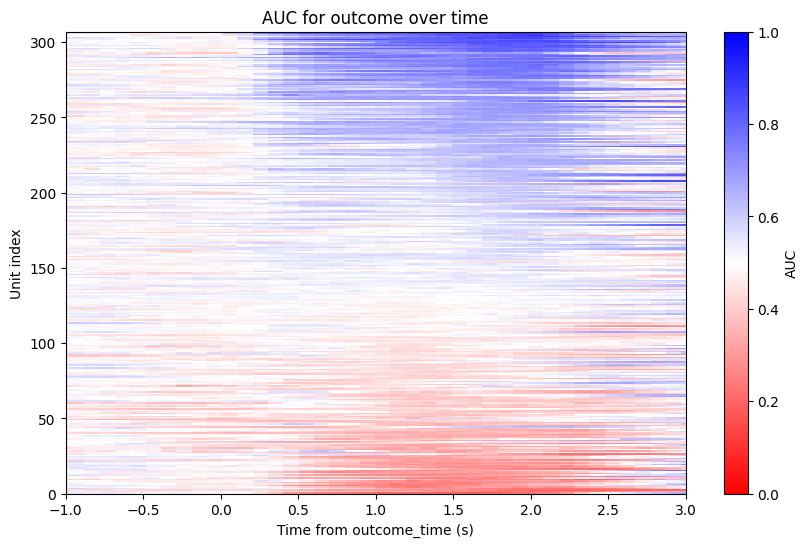

In [263]:
# Define custom colormap: white at 0, blue midrange, red at 1
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(10, 6))
    sort_ind = np.argsort(auc_max[:, label_ind], axis=0)
    plt.imshow(auc_mat[sort_ind, :, label_ind], aspect='auto', origin='lower', 
               extent=[slide_times_auc[0], slide_times_auc[-1], 0, len(combined_tagged_units_filtered)], 
               cmap=feature_map[label], vmin=0, vmax=1, interpolation='none')
    plt.colorbar(label='AUC')
    plt.title(f'AUC for {label} over time')
    plt.xlabel(f'Time from {align} (s)')
    plt.ylabel('Unit index')
    plt.xlim(-1, 3)
    plt.savefig(os.path.join(target_folder, f'AUC_{label}_{criteria_name}_{align}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(target_folder, f'AUC_{label}_{criteria_name}_{align}.svg'), bbox_inches='tight')

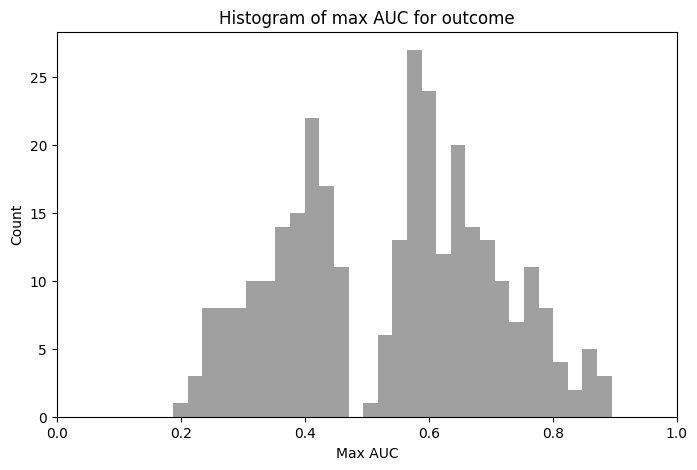

In [265]:
# histograms of max AUC
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(8, 5))
    sns.histplot(auc_max[:, label_ind], bins=30, kde=False, color='gray', edgecolor=None)
    plt.title(f'Histogram of max AUC for {label}')
    plt.xlabel('Max AUC')
    plt.ylabel('Count')
    plt.xlim(0, 1)
    plt.savefig(os.path.join(target_folder, f'AUC_max_hist_{label}_{criteria_name}_{align}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(target_folder, f'AUC_max_hist_{label}_{criteria_name}_{align}.svg'), bbox_inches='tight')

In [244]:
if binSize <=0.8:
    print("Saving short window results")
    auc_max_ind_short = auc_max_ind.copy()
    auc_max_short = auc_max.copy()
    auc_mat_short = auc_mat.copy()
    slide_times_auc_short = slide_times_auc.copy()
else:
    print("Saving long window results")
    auc_max_ind_long = auc_max_ind.copy()
    auc_max_long = auc_max.copy()
    auc_mat_long = auc_mat.copy()
    slide_times_auc_long = slide_times_auc.copy()

Saving long window results


In [246]:
# plot auROC with combined window
cut_time = 0.1
# concatenate short and long window results by long before cut time and short after cut time
long_mask = slide_times_auc_long <= cut_time
short_mask = slide_times_auc_short > cut_time
auc_mat_combined = np.concatenate((auc_mat_long[:, long_mask, :], auc_mat_short[:, short_mask, :]), axis=1)
slide_times_auc_combined = np.concatenate((slide_times_auc_long[long_mask], slide_times_auc_short[short_mask]))

In [247]:
max_periods = {'outcome': (0.0, 2.0),
               'hit': (-1, -0.1),
               'svs': (0.1, 0.7)}
for label in labels:
    label_ind = labels.index(label)
    period = max_periods[label]
    period_mask = (slide_times_auc >= period[0]) & (slide_times_auc <= period[1])
    for i in range(len(auc_max_ind)):
        valid_inds = np.where(period_mask & ~np.isnan(auc_mat[i][:, label_ind]))[0]
        best_ind_in_valid = valid_inds[np.argmax(np.abs(auc_mat[i][valid_inds, label_ind]-0.5))]
        auc_max_ind[i][label_ind] = best_ind_in_valid
        auc_max[i][label_ind] = auc_mat[i][best_ind_in_valid, label_ind]


auc_max_short = np.array(auc_max)
auc_max_ind_short = np.array(auc_max_ind)

In [251]:
max_periods = {'outcome': (0.0, 2.0),
               'hit': (-1, -0.1),
               'svs': (0.1, 0.5)}
sort_window = 'short'
if sort_window == 'short':
    auc_mat_sort = auc_mat_short.copy()
elif sort_window == 'long':
    auc_mat_sort = auc_mat_long.copy()
    
auc_max_ind = np.full(auc_max.shape, np.nan)
auc_max = np.full(auc_max.shape, np.nan)

for label in labels:
    label_ind = labels.index(label)
    period = max_periods[label]
    if sort_window == 'short':
        period_mask = (slide_times_auc_short >= period[0]) & (slide_times_auc_short <= period[1])
    elif sort_window == 'long':
        period_mask = (slide_times_auc_long >= period[0]) & (slide_times_auc_long <= period[1])
    for i in range(len(auc_max_ind)):
        valid_inds = np.where(period_mask & ~np.isnan(auc_mat_sort[i][:, label_ind]))[0]
        best_ind_in_valid = valid_inds[np.argmax(np.abs(auc_mat_sort[i][valid_inds, label_ind]-0.5))]
        auc_max_ind[i][label_ind] = best_ind_in_valid
        auc_max[i][label_ind] = auc_mat_sort[i][best_ind_in_valid, label_ind]


auc_max = np.array(auc_max)
auc_max_ind = np.array(auc_max_ind)

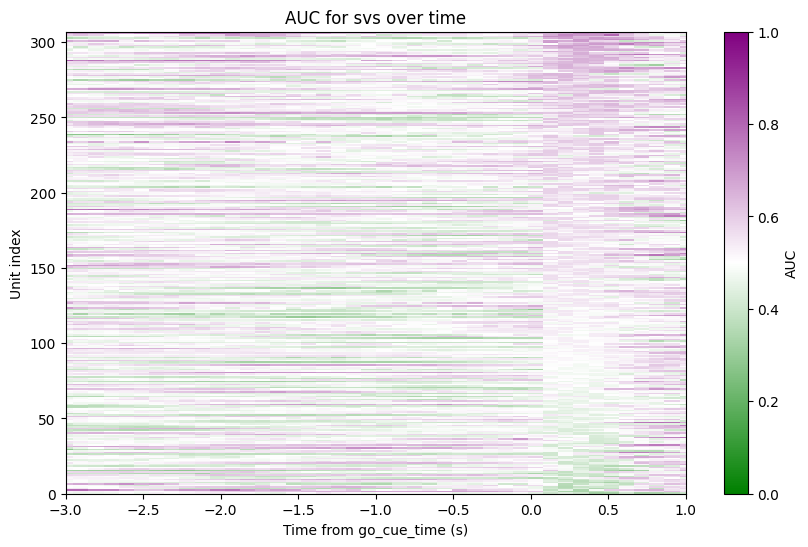

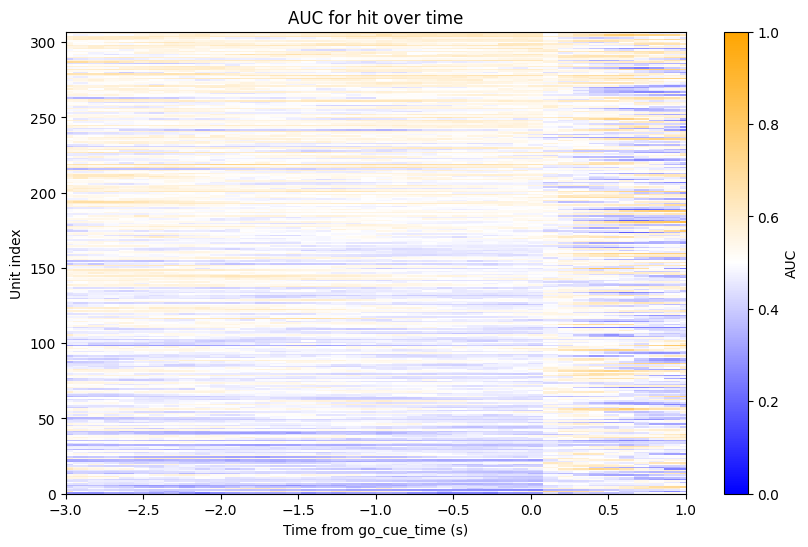

In [252]:
# Define custom colormap: white at 0, blue midrange, red at 1
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(10, 6))
    sort_ind_temp = np.argsort(auc_max[:, label_ind], axis=0)
    plt.imshow(auc_mat_combined[sort_ind_temp, :, label_ind], aspect='auto', origin='lower', 
               extent=[slide_times_auc_combined[0], slide_times_auc_combined[-1], 0, len(combined_tagged_units_filtered)], 
               cmap=feature_map[label], vmin=0, vmax=1, interpolation='none')
    plt.colorbar(label='AUC')
    plt.title(f'AUC for {label} over time')
    plt.xlabel(f'Time from {align} (s)')
    plt.ylabel('Unit index')
    plt.xlim(-3, 1)
    plt.savefig(os.path.join(target_folder, f'AUC_combined_{label}_{criteria_name}_{align}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(target_folder, f'AUC_combined_{label}_{criteria_name}_{align}.svg'), bbox_inches='tight')

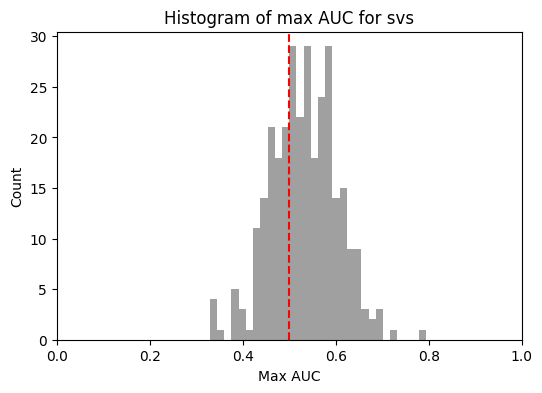

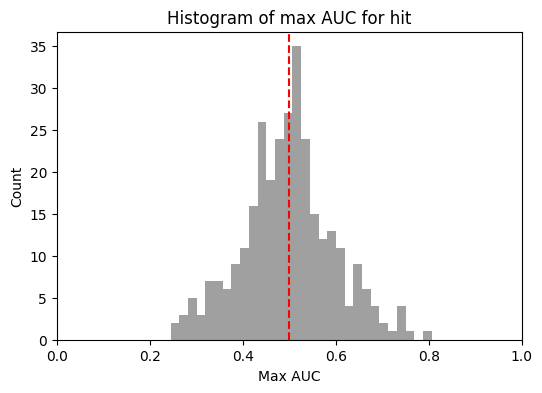

In [253]:
# histgrams of auc max
time_focus = 0.5
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(6, 4))
    sns.histplot(auc_mat_combined[:, np.argmin(np.abs(slide_times_auc_combined-time_focus)), label_ind], bins=30, kde=False, color='gray', edgecolor='None')
    plt.axvline(0.5, color='red', linestyle='--')
    plt.title(f'Histogram of max AUC for {label}')
    plt.xlabel('Max AUC')
    plt.ylabel('Count')
    plt.xlim(0, 1)
    plt.savefig(os.path.join(target_folder, f'AUC_max_hist_{label}_{time_focus}_{align}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(target_folder, f'AUC_max_hist_{label}_{time_focus}_{align}.svg'), bbox_inches='tight')